<h1 style="color: #001a79;">Anomaly Detection using Keras</h1>

<hr style="border-top: 1px solid #001a79;" />

** making a start to this notebook

Link to keras - timeseries anomaly detection here. Start research! 

https://keras.io/examples/timeseries/timeseries_anomaly_detection/

To do:

- On the keras5 website, there is an example of time-series anomaly detection  


- Re-create this example in a notebook of your own, explaining the concepts


- clearly explain each keras function used, referring to the documentation.


<h2 style="color: #001a79;">Introduction</h2>

<hr style="border-top: 1px solid #001a79;" />

To do:

Include an introduction to your notebook, setting the context and
describing what the reader can expect as they read down through
the notebook.




`It tries to learn a smaller representation of its input (encoder) and then reconstruct its input from that smaller representation (decoder). An anomaly score is designed to correspond to the reconstruction error.`

Nice article here: https://thingsolver.com/time-series-anomaly-detection-using-a-variational-autoencoder-vae/#:~:text=It%20tries%20to%20learn%20a,)%2C%20a%20Bayesian%20neural%20network.

This notebook is a re-creation of the timeseries anomaly detection using an Autoencoder in my own words. All code can be found on offical documentation here: https://keras.io/examples/timeseries/timeseries_anomaly_detection/

The goal is to display how we can reconstruct convilutional autoencoder model to detect anomalies using a timeseries.

In other words, we will use keras on top of tensorflow to build and train a model and then detect the anomolies. 

<h3 style="color: #001a79;">Importing Modules</h3>

<hr style="border-top: 1px solid #001a79;" />

In [1]:
# For numerical arrrays.
import numpy as np

# Dealing with dataframes. 
import pandas as pd

# For 
from tensorflow import keras

# For 
from tensorflow.keras import layers

# For data visualisation. 
from matplotlib import pyplot as plt

MAYBE SOME INFO ON TENSORFLOW HERE

WORKING ON IMPORTING TENSORFLOW TO MY MACHINE. 



<h3 style="color: #001a79;">TensorFlow</h3>


Tensorflow is a platform widely using in machine learning and statistics. It purpose is to aid with data automation, model tracking, performance monitoring and model retraining. 

Offical documentation can be found here: https://www.tensorflow.org/learn

<h3 style="color: #001a79;">Keras</h3>


Keras is a deep learning API which runs on top of TensorFlow. It's purpose is to provide a simple and flexible way of experimenting with ideas and producing fast results. It is an important library for completeing research. 


Offical documentation can be accessed here: https://keras.io/


<h3 style="color: #001a79;">Loading the Data</h3>

<hr style="border-top: 1px solid #001a79;" />

In [2]:
# Load the data

master_url_root = "https://raw.githubusercontent.com/numenta/NAB/master/data/"

df_small_noise_url_suffix = "artificialNoAnomaly/art_daily_small_noise.csv"
df_small_noise_url = master_url_root + df_small_noise_url_suffix
df_small_noise = pd.read_csv(
    df_small_noise_url, parse_dates=True, index_col="timestamp"
)

df_daily_jumpsup_url_suffix = "artificialWithAnomaly/art_daily_jumpsup.csv"
df_daily_jumpsup_url = master_url_root + df_daily_jumpsup_url_suffix
df_daily_jumpsup = pd.read_csv(
    df_daily_jumpsup_url, parse_dates=True, index_col="timestamp"
)

In [3]:
# Quick look at the data

print(df_small_noise.head())

print(df_daily_jumpsup.head())

                         value
timestamp                     
2014-04-01 00:00:00  18.324919
2014-04-01 00:05:00  21.970327
2014-04-01 00:10:00  18.624806
2014-04-01 00:15:00  21.953684
2014-04-01 00:20:00  21.909120
                         value
timestamp                     
2014-04-01 00:00:00  19.761252
2014-04-01 00:05:00  20.500833
2014-04-01 00:10:00  19.961641
2014-04-01 00:15:00  21.490266
2014-04-01 00:20:00  20.187739
                         value
timestamp                     
2014-04-01 00:00:00  18.324919
2014-04-01 00:05:00  21.970327
2014-04-01 00:10:00  18.624806
2014-04-01 00:15:00  21.953684
2014-04-01 00:20:00  21.909120
                         value
timestamp                     
2014-04-01 00:00:00  19.761252
2014-04-01 00:05:00  20.500833
2014-04-01 00:10:00  19.961641
2014-04-01 00:15:00  21.490266
2014-04-01 00:20:00  20.187739


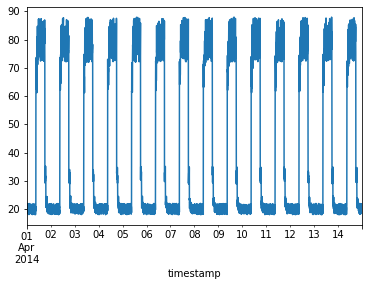

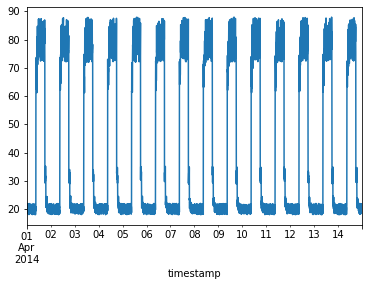

In [4]:
# Visualize the data

fig, ax = plt.subplots()
df_small_noise.plot(legend=False, ax=ax)
plt.show()

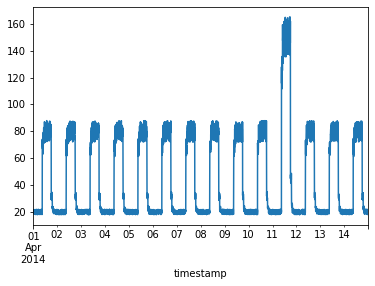

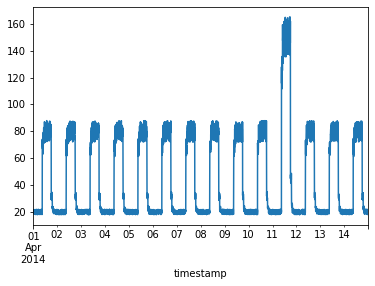

In [5]:
# Timeseries data with anomalies

fig, ax = plt.subplots()
df_daily_jumpsup.plot(legend=False, ax=ax)
plt.show()

<h3 style="color: #001a79;">Building a Model</h3>

<hr style="border-top: 1px solid #001a79;" />

In [6]:
# Prepare training data

# Normalize and save the mean and std we get,
# for normalizing test data.
training_mean = df_small_noise.mean()
training_std = df_small_noise.std()
df_training_value = (df_small_noise - training_mean) / training_std
print("Number of training samples:", len(df_training_value))

Number of training samples: 4032
Number of training samples: 4032


In [7]:
# Create sequences

TIME_STEPS = 288

# Generated training sequences for use in the model.
def create_sequences(values, time_steps=TIME_STEPS):
    output = []
    for i in range(len(values) - time_steps + 1):
        output.append(values[i : (i + time_steps)])
    return np.stack(output)


x_train = create_sequences(df_training_value.values)
print("Training input shape: ", x_train.shape)

Training input shape:  (3745, 288, 1)
Training input shape:  (3745, 288, 1)


In [8]:
# Build a model

model = keras.Sequential(
    [
        layers.Input(shape=(x_train.shape[1], x_train.shape[2])),
        layers.Conv1D(
            filters=32, kernel_size=7, padding="same", strides=2, activation="relu"
        ),
        layers.Dropout(rate=0.2),
        layers.Conv1D(
            filters=16, kernel_size=7, padding="same", strides=2, activation="relu"
        ),
        layers.Conv1DTranspose(
            filters=16, kernel_size=7, padding="same", strides=2, activation="relu"
        ),
        layers.Dropout(rate=0.2),
        layers.Conv1DTranspose(
            filters=32, kernel_size=7, padding="same", strides=2, activation="relu"
        ),
        layers.Conv1DTranspose(filters=1, kernel_size=7, padding="same"),
    ]
)
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001), loss="mse")
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
Model: "sequential"
 conv1d (Conv1D)             (None, 144, 32)           256       
                                                                 
 dropout (Dropout)           (None, 144, 32)           0         
                                                                 
 conv1d_1 (Conv1D)           (None, 72, 16)            3600      
                                                                 
 conv1d_transpose (Conv1DTra  (None, 144, 16)          1808      
 nspose)                                                         
                                                                 
 dropout_1 (Dropout)         (None, 144, 16)           0         
                                                                 
_________________________________________________________________
 Layer (type)                Output 

In [9]:
# Train the model

history = model.fit(
    x_train,
    x_train,
    epochs=50,
    batch_size=128,
    validation_split=0.1,
    callbacks=[
        keras.callbacks.EarlyStopping(monitor="val_loss", patience=5, mode="min")
    ],
)

Epoch 1/50
Epoch 1/50
27/27 [==============================] - 15s 227ms/step - loss: 0.4837 - val_loss: 0.2978
Epoch 2/50
Epoch 2/50
27/27 [==============================] - 4s 163ms/step - loss: 0.1572 - val_loss: 0.0448
Epoch 3/50
Epoch 3/50
27/27 [==============================] - 4s 159ms/step - loss: 0.0574 - val_loss: 0.0363
Epoch 4/50
Epoch 4/50
27/27 [==============================] - 5s 170ms/step - loss: 0.0458 - val_loss: 0.0346
Epoch 5/50
27/27 [==============================] - 5s 170ms/step - loss: 0.0458 - val_loss: 0.0346
Epoch 5/50
27/27 [==============================] - 5s 165ms/step - loss: 0.0401 - val_loss: 0.0309
Epoch 6/50
Epoch 6/50
27/27 [==============================] - 5s 184ms/step - loss: 0.0361 - val_loss: 0.0294
Epoch 7/50
Epoch 7/50
27/27 [==============================] - 8s 277ms/step - loss: 0.0329 - val_loss: 0.0273
Epoch 8/50
Epoch 8/50
27/27 [==============================] - 6s 224ms/step - loss: 0.0303 - val_loss: 0.0284
Epoch 9/50
Epoch 9/50


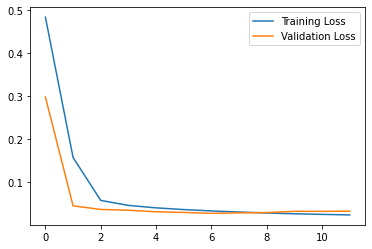

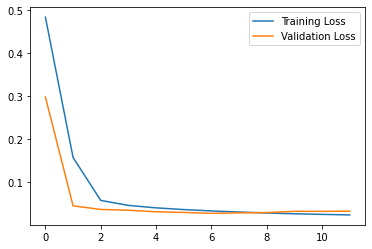

In [10]:
# Let's plot training and validation loss to see how the training went.

plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.legend()
plt.show()

<h3 style="color: #001a79;">Detecting Anomalies</h3>

<hr style="border-top: 1px solid #001a79;" />

118/118 [==============================] - 4s 25ms/step


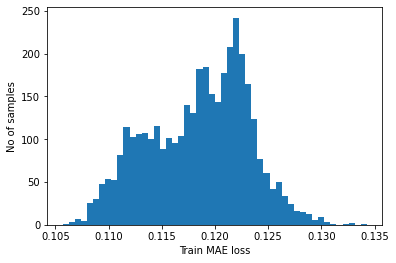

Reconstruction error threshold:  0.13427800884524999


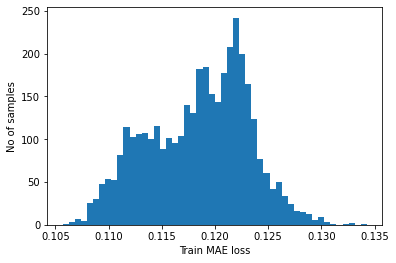

Reconstruction error threshold:  0.13427800884524999


In [11]:
# Detecting anomalies

# Get train MAE loss.
x_train_pred = model.predict(x_train)
train_mae_loss = np.mean(np.abs(x_train_pred - x_train), axis=1)

plt.hist(train_mae_loss, bins=50)
plt.xlabel("Train MAE loss")
plt.ylabel("No of samples")
plt.show()

# Get reconstruction loss threshold.
threshold = np.max(train_mae_loss)
print("Reconstruction error threshold: ", threshold)

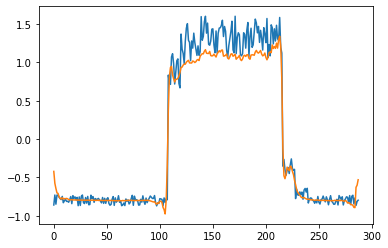

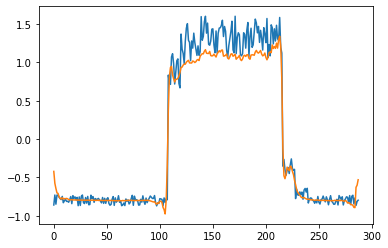

In [12]:
# Compare recontruction

# Checking how the first sequence is learnt
plt.plot(x_train[0])
plt.plot(x_train_pred[0])
plt.show()

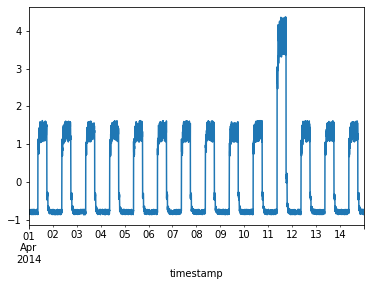

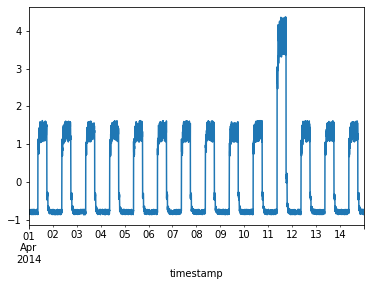

Test input shape:  (3745, 288, 1)
Test input shape:  (3745, 288, 1)
118/118 [==============================] - 3s 25ms/step


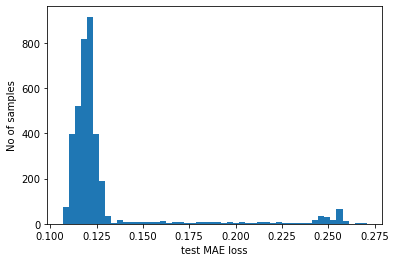

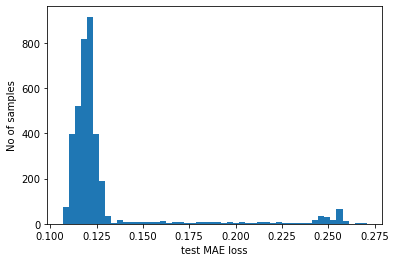

Number of anomaly samples:  391
Indices of anomaly samples:  (array([1654, 2702, 2703, 2704, 2705, 2706, 2707, 2709, 2710, 2711, 2712,
       2713, 2714, 2715, 2716, 2717, 2718, 2719, 2720, 2721, 2722, 2723,
       2724, 2725, 2726, 2727, 2728, 2729, 2730, 2731, 2732, 2733, 2734,
       2735, 2736, 2737, 2738, 2739, 2740, 2741, 2742, 2743, 2744, 2745,
       2746, 2747, 2748, 2749, 2750, 2751, 2752, 2753, 2754, 2755, 2756,
       2757, 2758, 2759, 2760, 2761, 2762, 2763, 2764, 2765, 2766, 2767,
       2768, 2769, 2770, 2771, 2772, 2773, 2774, 2775, 2776, 2777, 2778,
       2779, 2780, 2781, 2782, 2783, 2784, 2785, 2786, 2787, 2788, 2789,
       2790, 2791, 2792, 2793, 2794, 2795, 2796, 2797, 2798, 2799, 2800,
       2801, 2802, 2803, 2804, 2805, 2806, 2807, 2808, 2809, 2810, 2811,
       2812, 2813, 2814, 2815, 2816, 2817, 2818, 2819, 2820, 2821, 2822,
       2823, 2824, 2825, 2826, 2827, 2828, 2829, 2830, 2831, 2832, 2833,
       2834, 2835, 2836, 2837, 2838, 2839, 2840, 2841, 2842, 2

In [13]:
# Prepare test data

df_test_value = (df_daily_jumpsup - training_mean) / training_std
fig, ax = plt.subplots()
df_test_value.plot(legend=False, ax=ax)
plt.show()

# Create sequences from test values.
x_test = create_sequences(df_test_value.values)
print("Test input shape: ", x_test.shape)

# Get test MAE loss.
x_test_pred = model.predict(x_test)
test_mae_loss = np.mean(np.abs(x_test_pred - x_test), axis=1)
test_mae_loss = test_mae_loss.reshape((-1))

plt.hist(test_mae_loss, bins=50)
plt.xlabel("test MAE loss")
plt.ylabel("No of samples")
plt.show()

# Detect all the samples which are anomalies.
anomalies = test_mae_loss > threshold
print("Number of anomaly samples: ", np.sum(anomalies))
print("Indices of anomaly samples: ", np.where(anomalies))

In [14]:
# Plot anomalies

# data i is an anomaly if samples [(i - timesteps + 1) to (i)] are anomalies
anomalous_data_indices = []
for data_idx in range(TIME_STEPS - 1, len(df_test_value) - TIME_STEPS + 1):
    if np.all(anomalies[data_idx - TIME_STEPS + 1 : data_idx]):
        anomalous_data_indices.append(data_idx)

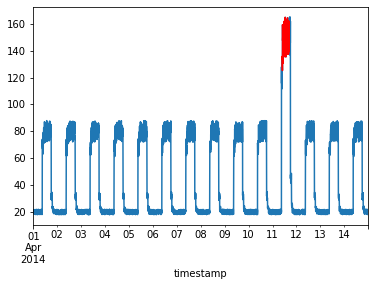

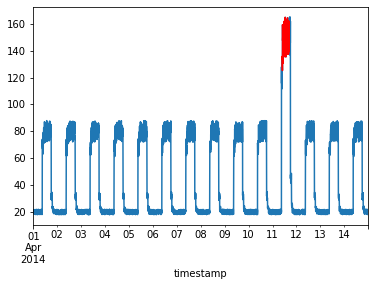

In [15]:
# Let's overlay the anomalies on the original test data plot.

df_subset = df_daily_jumpsup.iloc[anomalous_data_indices]
fig, ax = plt.subplots()
df_daily_jumpsup.plot(legend=False, ax=ax)
df_subset.plot(legend=False, ax=ax, color="r")
plt.show()

<h2 style="color: #001a79;">Conclusion</h2>

<hr style="border-top: 1px solid #001a79;" />

To do:

Include a conclusion section where you suggest improvements you
could make to the analysis in the notebook.


<hr style="border-top: 1px solid #001a79;" />

<h2 style="color: #001a79;">End</h2>